In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as mplot
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
import subprocess
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score,  precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
 
import random
 

from sklearn.preprocessing import StandardScaler


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.datasets import mnist
#from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model



from sklearn.tree import export_graphviz
import seaborn as sns
 

In [2]:
dataSetIndex = 4 
needToMakePictureOfTrees = 0
''' ---------------------------------------------------------- '''
dataSetFilePath = ""
dataSetName = ""
dataSetResultDirectory = "./"

if(dataSetIndex == 0):
    dataSetFilePath = "./heartDisease/0_statLog_dataSet.csv"
    dataSetName = "SateLog"
elif (dataSetIndex == 1):
    dataSetFilePath = "./heartDisease/1_heart_statlog_cleveland_hungary_final.csv"
    dataSetName = "ALL_StateLog_CleveLand_Hungary"
elif (dataSetIndex == 2):
    dataSetFilePath = "./heartDisease/2_cleveland.csv"
    dataSetName = "Cleveland"
elif (dataSetIndex == 3):
    dataSetFilePath = "./heartDisease/3_framingham.csv"
    dataSetName = "framingham"
elif (dataSetIndex == 4):
    dataSetFilePath = "./heartDisease/4_CardiacPrediction.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 5):
    dataSetFilePath = "./heartDisease/5_CardiacPredictionLessDimensions.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 6):
    dataSetFilePath = "./heartDisease/6_CardiacPredictionFewDimensions.xlsx"
    dataSetName = "CardiacPrediction"
else:
    dataSetFilePath = ""
    dataSetName = ""

if(dataSetIndex==4 or dataSetIndex==5 or dataSetIndex==6):
    #fileData = pd.read_excel(dataSetFilePath, sheet_name='CoroHeartDis')
    fileData = pd.read_excel(dataSetFilePath)
else:
    fileData = pd.read_csv(dataSetFilePath)

print("Shape of fileData: {}".format(fileData.shape))
print("Column Headings: {}".format(fileData.__dataframe__().column_names()))
print("Number of Records: {}".format(fileData.__dataframe__().num_rows()))


missingValues = fileData.isnull().any().sum()
print(f"\nNumber of Missing Values: {missingValues}")

num_rows_before = fileData.shape[0]
# Remove duplicate records based on all columns
fileData.drop_duplicates(inplace=True)
# Check the number of rows after removing duplicates
num_rows_after = fileData.shape[0]
# Print the number of duplicate records removed
num_duplicates_removed = num_rows_before - num_rows_after
print(f"Number of duplicate records removed: {num_duplicates_removed}")
 
 # Preprocess Steps from the ChatGPT
# 1. Handling Missing Values:
fileData = fileData.dropna()
print("Shape of fileData: {}".format(fileData.shape))              
#fileData.replace({'?': np.nan}).dropna().astype(float)
#fileData = fileData.fillna(0) 

fileData = fileData.fillna(0) 

print("Shape of fileData End: {}".format(fileData.shape))
 
 

X = fileData.drop(fileData.__dataframe__().column_names()[-1], axis=1)  # Features
Y = fileData[fileData.__dataframe__().column_names()[-1]]  # Labels

columns = fileData.__dataframe__().column_names() 
totalRecords = (fileData.__dataframe__().num_rows())

print("\n")
print("columns of x:: {} \n\n and features of X: {}".format(len(X.columns), X.columns))




Shape of fileData: (37079, 51)
Column Headings: Index(['SEQN', 'Gender', 'Age', 'Annual-Family-Income',
       'Ratio-Family-Income-Poverty', 'X60-sec-pulse', 'Systolic', 'Diastolic',
       'Weight', 'Height', 'Body-Mass-Index', 'White-Blood-Cells',
       'Lymphocyte', 'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells',
       'Hemoglobin', 'Mean-Cell-Vol', 'Mean-Cell-Hgb-Conc.',
       'Mean-cell-Hemoglobin', 'Platelet-count', 'Mean-Platelet-Vol',
       'Segmented-Neutrophils', 'Hematocrit', 'Red-Cell-Distribution-Width',
       'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose',
       'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Vigorous-work', 'Moderate-work', 'Health-Insurance', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke', 'CoronaryHeartDisease'],
      dtype='object')
Number of Records: 37079

Number of Missing Values: 0
Number o

Top 30 features based on correlation:
Total-Cholesterol            Cholesterol                    0.983762
Cholesterol                  Total-Cholesterol              0.983762
Hematocrit                   Hemoglobin                     0.965886
Hemoglobin                   Hematocrit                     0.965886
Segmented-Neutrophils        Lymphocyte                     0.936228
Lymphocyte                   Segmented-Neutrophils          0.936228
Mean-Cell-Hgb-Conc.          Mean-Cell-Vol                  0.933717
Mean-Cell-Vol                Mean-Cell-Hgb-Conc.            0.933717
Body-Mass-Index              Weight                         0.873545
Weight                       Body-Mass-Index                0.873545
Ratio-Family-Income-Poverty  Annual-Family-Income           0.871092
Annual-Family-Income         Ratio-Family-Income-Poverty    0.871092
Red-Blood-Cells              Hematocrit                     0.814239
Hematocrit                   Red-Blood-Cells                0.814

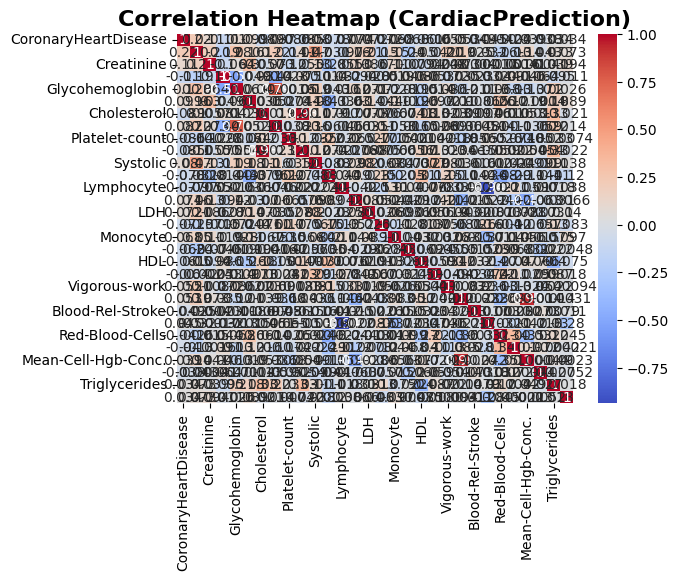

In [3]:

def makeCorrelationPic(correlationMatrix, numberOfTopFeatures, targetColumnName):     
    correlation_values = correlationMatrix.abs()
    sorted_correlation = correlation_values.unstack().sort_values(ascending=False)
    sorted_correlation = sorted_correlation[sorted_correlation != 1.0]

    num_features = numberOfTopFeatures  # Number of top features to display
    top_features = sorted_correlation.head(num_features)
    print("Top", num_features, "features based on correlation:")
    print(top_features)
 
    top_features = correlationMatrix.abs().nlargest(numberOfTopFeatures, targetColumnName)[targetColumnName].index
    top_correlation_matrix = correlationMatrix.loc[top_features, top_features]

    mplot.figure(figsize=(20, 16)) 
    sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm')
    # Set the title of the plot
    mplot.title('Correlation Heatmap ({})'.format(dataSetName)  ,fontsize=16, fontweight='bold')
    
    picturePath = "{}0.1_Correlation_Matrix_DateSetName_{}.png".format(dataSetResultDirectory, dataSetName)
    print(picturePath)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    mplot.show()
    mplot.close()
    
# Calculate the correlation matrix 
correlation_matrix = fileData.corr()
#makeCorrelationPic(correlation_matrix, 15, 'CoronaryHeartDisease') 

makeCorrelationPic(correlation_matrix, 30, fileData.__dataframe__().column_names()[-1] ) 

In [3]:
print("Shape of fileData: {} , target Len:{}".format(fileData.shape, len(Y)))
print("X: {} , Y:{}".format(X.shape, Y.shape))
#print("\n\nX: head:: \n{}".format(X.head()))
#print("\n\nY: head::\n {}".format(Y.head()))

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=42)
 

print("Target Column Name:: {} \n".format(fileData.__dataframe__().column_names()[-1]))

# Undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_, y_train_ = rus.fit_resample(X_train, y_train)
X_test_, y_test_ = rus.fit_resample(X_test, y_test)
'''

# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

'''

# Print the class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_train_).value_counts())




print("\n X Train: Shape:: {}".format(X_train_.shape))
print(" X Test: Shape:: {}".format(X_test_.shape))

'''
print("\n X Train: Shape::\n {}".format(X_train.shape))
print("\n X Train: head::\n {}".format(X_train.columns))
print("\n X Test: head:: \n{}".format(X_test.columns))
print("\n Y Train: shape::\n {}".format(y_train.shape)) 
print("\n Y Test: shape::\n {}".format(y_test.shape)) 
'''
#print("\n X Train: Info::\n {}".format(X_train.info())) 


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_)
X_test_scaled = scaler.transform(X_test_)



instance = np.array(X_test_)  # Example: explaining the first instance in the dataset
 
dataSetResultDirectory += ("Dataset_Exploration_" + dataSetName)
dataSetResultDirectory += "/"
if not os.path.isdir(dataSetResultDirectory):
    os.makedirs(dataSetResultDirectory)

dataSetName += " {}".format(fileData.shape)


Shape of fileData: (37079, 51) , target Len:37079
X: (37079, 50) , Y:(37079,)
Target Column Name:: CoronaryHeartDisease 

Class distribution after undersampling:
CoronaryHeartDisease
0    1056
1    1056
Name: count, dtype: int64

 X Train: Shape:: (2112, 50)
 X Test: Shape:: (904, 50)


In [7]:
dt = fileData

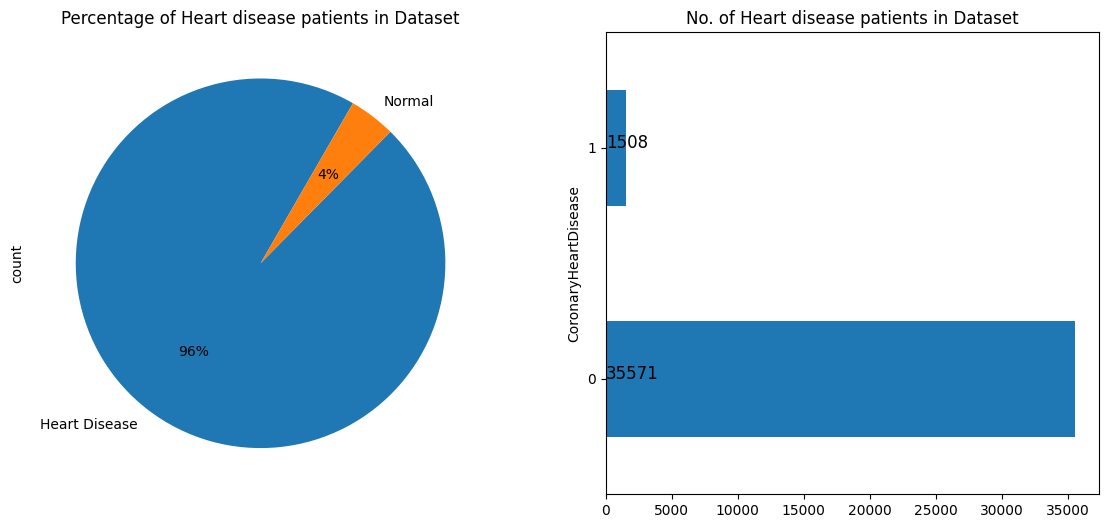

In [9]:
# Plotting attrition of employees
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(14,6))

ax1 = dt['CoronaryHeartDisease'].value_counts().plot.pie( x="Heart disease" ,y ='no.of patients', 
                   autopct = "%1.0f%%",labels=["Heart Disease","Normal"], startangle = 60,ax=ax1);
ax1.set(title = 'Percentage of Heart disease patients in Dataset')

ax2 = dt["CoronaryHeartDisease"].value_counts().plot(kind="barh" ,ax =ax2)
for i,j in enumerate(dt["CoronaryHeartDisease"].value_counts().values):
    ax2.text(.5,i,j,fontsize=12)
ax2.set(title = 'No. of Heart disease patients in Dataset')

'''
accuracyString ="Accuracy {}: {:.2f}".format(method, accuracy*100.0 ) 
recallString =  'Recall {}: {:.2f}'.format(method, recall_value* 100.0)
precisionString = 'Precision {}: {:.2f}'.format(method, precision_value * 100.0) 
dataSetString = "F1 Score: {}".format(f1_score_value * 100.0)
featureListString = "AUC Score: {}".format(auc_value * 100.0)
numberOfEpochsString = "Number of Epoches: {}".format(numberOfEpochs)
batchSizeOfTrainingString = "BatchSize for Epoch: {}".format(batchSizeOfTraining)

display.figure_.text(0.010, -0.05,  accuracyString, horizontalalignment='left', wrap=False )  
display.figure_.text(0.010, -0.09,  recallString, horizontalalignment='left', wrap=False )      
display.figure_.text(0.010, -0.13,  precisionString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.17,  dataSetString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.21,  featureListString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.28,  numberOfEpochsString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.32,  batchSizeOfTrainingString, horizontalalignment='left', wrap=False ) 
 
'''


picturePath = "{}DataSet_Exploration_No_Heart_Patients_{}.png".format(dataSetResultDirectory, dataSetName)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight') 

plt.show()

C:\Users\Mubashir Iqbal\AppData\Local\Temp\ipykernel_9880\3491084430.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax= sns.distplot(dt['Age'], rug=True)


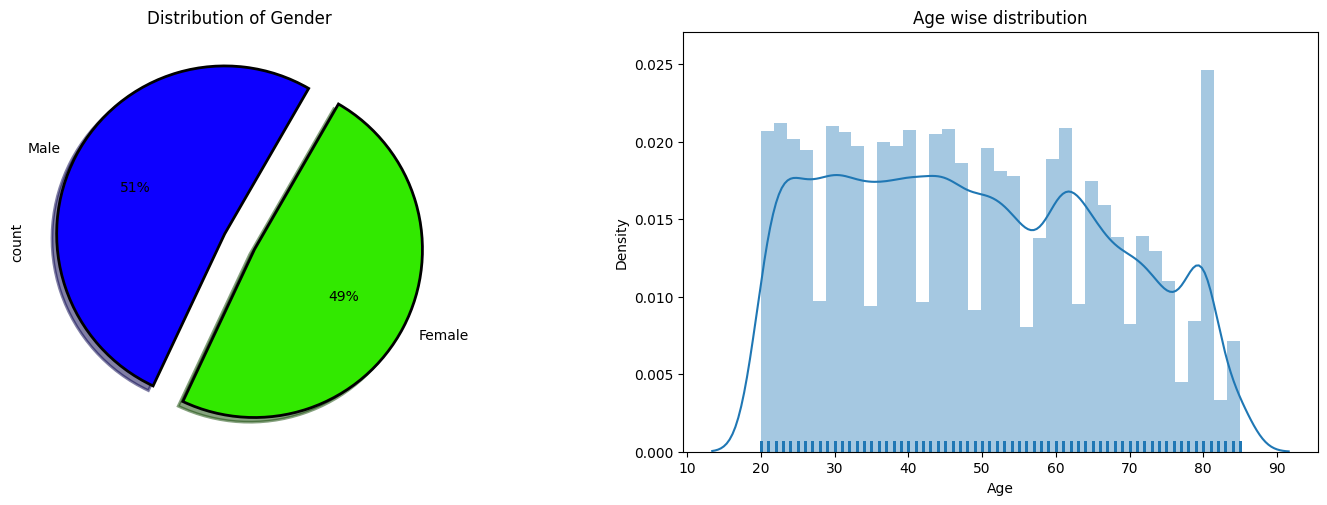

In [11]:
plt.figure(figsize=(18,12))
plt.subplot(221)
dt["Gender"].value_counts().plot.pie(autopct = "%1.0f%%",colors = sns.color_palette("prism",5),startangle = 60,labels=["Male","Female"],
wedgeprops={"linewidth":2,"edgecolor":"k"},explode=[.1,.1],shadow =True)
plt.title("Distribution of Gender")
plt.subplot(222)
ax= sns.distplot(dt['Age'], rug=True)
plt.title("Age wise distribution")
picturePath = "{}DataSet_Exploration_Age wise distribution_{}.png".format(dataSetResultDirectory, dataSetName)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight') 
plt.show()

C:\Users\Mubashir Iqbal\AppData\Local\Temp\ipykernel_9880\4013196973.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(attr_0['Age'])
C:\Users\Mubashir Iqbal\AppData\Local\Temp\ipykernel_9880\4013196973.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(attr_0['Gender'], palette='viridis')


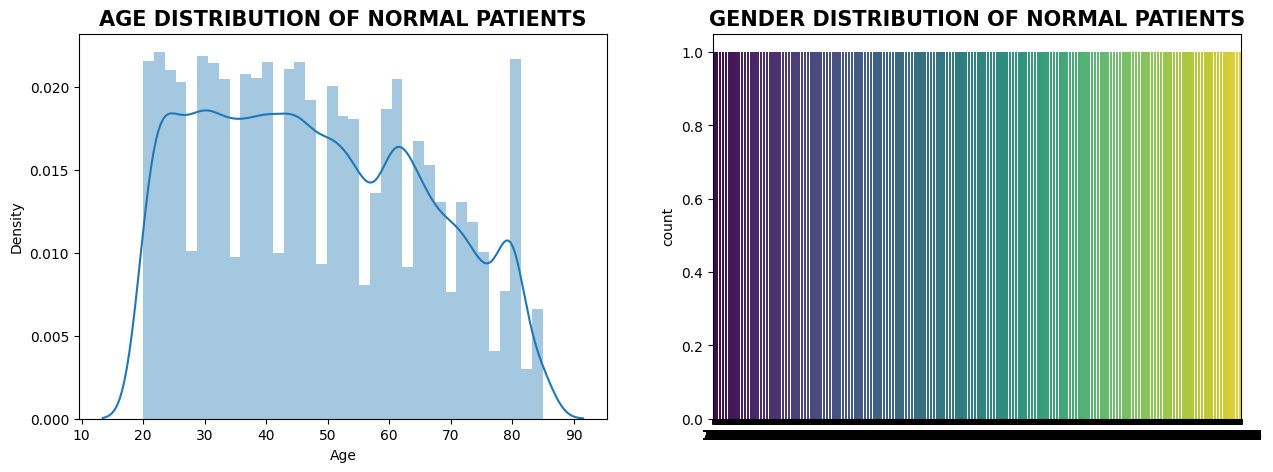

C:\Users\Mubashir Iqbal\AppData\Local\Temp\ipykernel_9880\4013196973.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(attr_1['Age'])
C:\Users\Mubashir Iqbal\AppData\Local\Temp\ipykernel_9880\4013196973.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(attr_1['Gender'], palette='viridis')


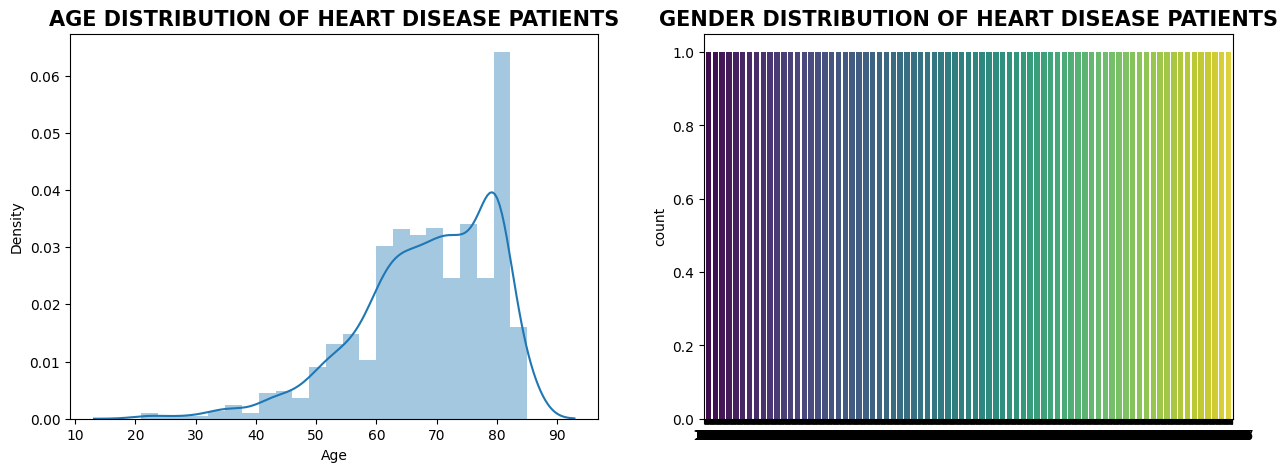

<Figure size 640x480 with 0 Axes>

In [14]:
# creating separate df for normal and heart patients

attr_1=dt[dt['CoronaryHeartDisease']==1]

attr_0=dt[dt['CoronaryHeartDisease']==0]

# plotting normal patients
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0))
sns.distplot(attr_0['Age'])
plt.title('AGE DISTRIBUTION OF NORMAL PATIENTS', fontsize=15, weight='bold')

ax1 = plt.subplot2grid((1,2),(0,1))
sns.countplot(attr_0['Gender'], palette='viridis')
plt.title('GENDER DISTRIBUTION OF NORMAL PATIENTS', fontsize=15, weight='bold' )
plt.show()

#plotting heart patients

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1,2),(0,0))
sns.distplot(attr_1['Age'])
plt.title('AGE DISTRIBUTION OF HEART DISEASE PATIENTS', fontsize=15, weight='bold')

ax1 = plt.subplot2grid((1,2),(0,1))
sns.countplot(attr_1['Gender'], palette='viridis')
plt.title('GENDER DISTRIBUTION OF HEART DISEASE PATIENTS', fontsize=15, weight='bold' )
plt.show()


picturePath = "{}DataSet_Exploration_Age wise distribution2_{}.png".format(dataSetResultDirectory, dataSetName)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight') 

<Axes: title={'center': 'Correlation of Heart Disease'}>

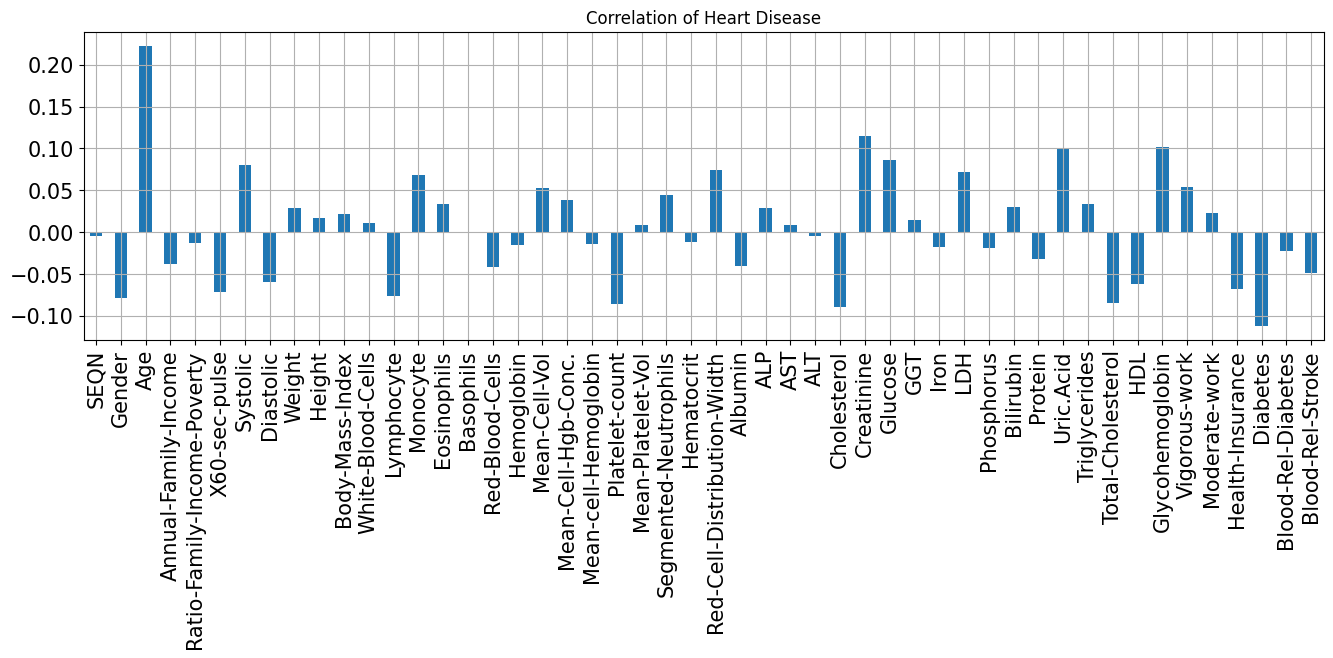

In [15]:
X.corrwith(Y).plot.bar( figsize = (16, 4), title = "Correlation of Heart Disease", fontsize = 15, rot = 90, grid = True)

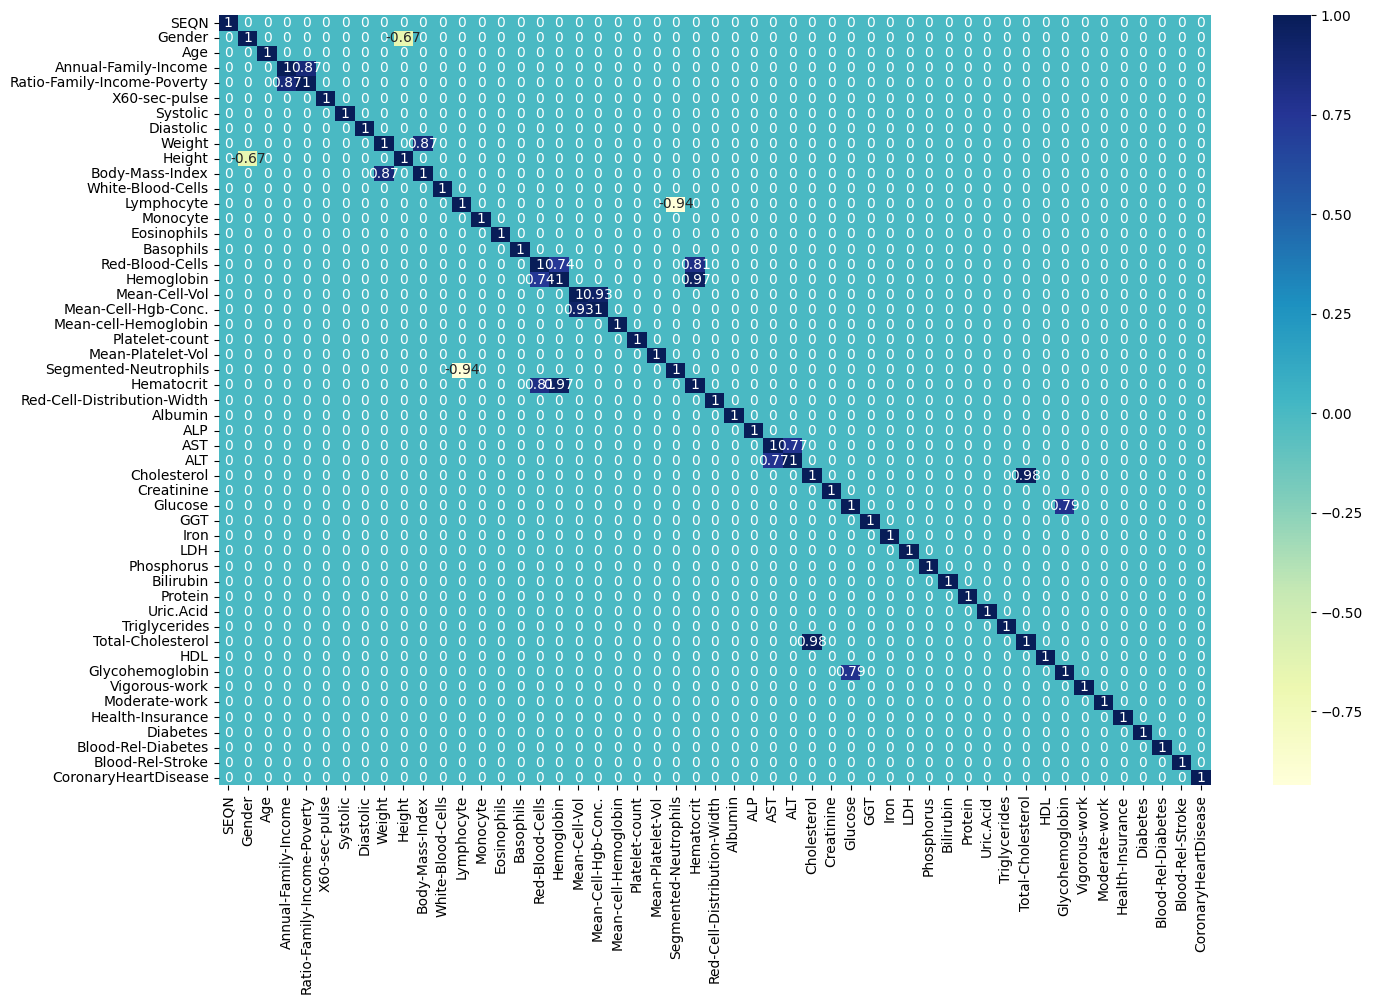

In [16]:
import seaborn as sns
pd.options.display.float_format = '{:,.4f}'.format
corr = dt.corr()
corr[np.abs(corr) < 0.65] = 0
plt.figure(figsize=(16,10))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.show()